# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [1]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [5]:
from nltk import wordpunct_tokenize
from nltk import FreqDist

## gazeta

Загрузим датасет gazeta. Одновременно сделаем преобразование даты из строки

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [3]:
data_gazeta = pd.read_csv('../data/gazeta.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"',
                      error_bad_lines=False)

b'Skipping line 437258: expected 17 fields, saw 20\n'
b'Skipping line 591054: expected 17 fields, saw 20\n'
b'Skipping line 780302: expected 17 fields, saw 20\n'
b'Skipping line 793371: expected 17 fields, saw 20\n'
b'Skipping line 838172: expected 17 fields, saw 20\n'
/home/avenon/anaconda2/envs/proj_news_viz/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Проверим преобразование
data_gazeta.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors                object
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [7]:
data_gazeta.shape

(865847, 16)

In [8]:
# Так выглядет датасет gazeta
data_gazeta.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2008-11-21 15:19:14,https://www.gazeta.ru/news/business/2008/11/21...,-,Бизнес,NaN,Госдума сокращает срок действия ставки экспорт...,Госдума приняла сегодня в первом чтении и сраз...,-,-,-,-,-,-,-,-,-
1,2012-09-27 10:54:51,https://www.gazeta.ru/science/news/2012/09/27/...,-,Наука,NaN,Японские физики повторили синтез 113-го элемента,Японские ученые из физического центра RIKEN за...,-,-,-,-,-,-,-,-,-
2,2015-12-01 15:28:45,https://www.gazeta.ru/army/news/7957079.shtml,-,Армия,NaN,Times: Россия строит новую авиабазу в Сирии,Россия готовится расширить свою военную операц...,-,-,-,-,-,-,-,-,-
3,2013-04-18 16:42:06,https://www.gazeta.ru/travel/news/2013/04/18/n...,-,Новости,NaN,Власти Египта гарантируют безопасность российс...,Египет ждет российских туристов и гарантирует ...,-,-,-,-,-,-,-,-,-
4,2012-09-26 13:54:13,https://www.gazeta.ru/politics/news/2012/09/26...,-,Политика,NaN,Гордума Новочеркасска приняла отставку мэра го...,В Ростовской области депутаты гордумы Новочерк...,-,-,-,-,-,-,-,-,-


In [9]:
# Выясним в каким столбцах есть пустые данные
data_gazeta.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text           False
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

Как видим, в некоторых столбцах вместо значения Nan используется "-", их преобразованием займемся позже. А пока посмотрим строки, в которых пустые тексты новостей

In [10]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_gazeta['authors'].isnull().sum())
data_gazeta[data_gazeta['authors'].isnull()]

Кол-во строк с значением NaN в столбце "authors" =  801505


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2008-11-21 15:19:14,https://www.gazeta.ru/news/business/2008/11/21...,-,Бизнес,NaN,Госдума сокращает срок действия ставки экспорт...,Госдума приняла сегодня в первом чтении и сраз...,-,-,-,-,-,-,-,-,-
1,2012-09-27 10:54:51,https://www.gazeta.ru/science/news/2012/09/27/...,-,Наука,NaN,Японские физики повторили синтез 113-го элемента,Японские ученые из физического центра RIKEN за...,-,-,-,-,-,-,-,-,-
2,2015-12-01 15:28:45,https://www.gazeta.ru/army/news/7957079.shtml,-,Армия,NaN,Times: Россия строит новую авиабазу в Сирии,Россия готовится расширить свою военную операц...,-,-,-,-,-,-,-,-,-
3,2013-04-18 16:42:06,https://www.gazeta.ru/travel/news/2013/04/18/n...,-,Новости,NaN,Власти Египта гарантируют безопасность российс...,Египет ждет российских туристов и гарантирует ...,-,-,-,-,-,-,-,-,-
4,2012-09-26 13:54:13,https://www.gazeta.ru/politics/news/2012/09/26...,-,Политика,NaN,Гордума Новочеркасска приняла отставку мэра го...,В Ростовской области депутаты гордумы Новочерк...,-,-,-,-,-,-,-,-,-
5,2012-09-26 21:11:33,https://www.gazeta.ru/culture/news/2012/09/26/...,-,Культура,NaN,"Министерство культуры назвало фильмы, на котор...",Министерство культуры России определило перече...,-,-,-,-,-,-,-,-,-
6,2011-02-24 16:40:29,https://www.gazeta.ru/news/sport/2011/02/24/n_...,-,Спорт,NaN,Иванов возглавил совет ПБК ЦСКА,Заместитель председателяnправительства РФnСерг...,-,-,-,-,-,-,-,-,-
7,2012-09-27 10:32:37,https://www.gazeta.ru/culture/news/2012/09/27/...,-,Культура,NaN,Коллегия Минкультуры обсудила отказ от бессроч...,Отказ от бессрочных контактов с артистами и вв...,-,-,-,-,-,-,-,-,-
8,2012-09-27 10:36:58,https://www.gazeta.ru/culture/news/2012/09/27/...,-,Культура,NaN,Театр «Россия» на Пушкинской площади открылся ...,Мэр Москвы Сергей Собянин в среду официально о...,-,-,-,-,-,-,-,-,-
9,2012-09-27 11:49:45,https://www.gazeta.ru/culture/news/2012/09/27/...,-,Культура,NaN,Речь Брейвика в суде станет основой театрально...,Немецко-швейцарская театральная труппа намерен...,-,-,-,-,-,-,-,-,-


In [11]:
print('authors: ',data_gazeta['authors'].unique())

authors:  [nan 'Александра Кошкина'
 'Анастасия Берсенева,Максим Солопов,Константин Новиков,Евгений Сафронов'
 ... 'Алина Распоповой' 'Анатолий Караваев,Юрий Воронцов'
 'Евгения Петрова (Сочи)']


Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [12]:
print('edition: ',data_gazeta['edition'].unique())
print('reposts_fb: ', data_gazeta['reposts_fb'].unique())
print('reposts_vk: ',data_gazeta['reposts_vk'].unique())
print('reposts_ok: ',data_gazeta['reposts_ok'].unique())
print('reposts_twi: ',data_gazeta['reposts_twi'].unique())
print('reposts_lj: ',data_gazeta['reposts_lj'].unique())
print('reposts_tg: ',data_gazeta['reposts_tg'].unique())
print('likes: ',data_gazeta['likes'].unique())
print('views: ',data_gazeta['views'].unique())
print('comm_count: ',data_gazeta['comm_count'].unique())

edition:  ['-']
reposts_fb:  ['-']
reposts_vk:  ['-']
reposts_ok:  ['-']
reposts_twi:  ['-']
reposts_lj:  ['-']
reposts_tg:  ['-']
likes:  ['-']
views:  ['-']
comm_count:  ['-']


In [13]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_gazeta.text.duplicated().sum())

Кол-во одинаковых текстов: 135


In [15]:
data_gazeta = data_gazeta.drop_duplicates(subset='text')

In [16]:
data_gazeta.shape

(865712, 16)

### Анализ дат

In [17]:
print('Минимальная дата в датасете:', data_gazeta.date.min())
print('Максимальная дата в датасете:', data_gazeta.date.max())

Минимальная дата в датасете: 2007-03-03 11:17:10
Максимальная дата в датасете: 2019-05-23 23:45:48


#### Распределение количества новостей по месяцам

In [18]:
# Вынесем месяц и год новости в отдельные столбцы
data_gazeta['month'] = data_gazeta.date.apply(lambda x: x.month)
data_gazeta['year'] = data_gazeta.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data_gazeta.groupby(['year', 'month']).text.nunique().reset_index()

In [19]:
df

,year,month,text
0,2007,3,245
1,2007,4,244
2,2007,7,1
3,2008,11,1
4,2009,2,1
5,2009,6,1
6,2009,12,1
7,2010,2,2
8,2010,4,201
9,2010,5,351


In [20]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [21]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [22]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [23]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False)

,month_year,nunique_text
91,03-2017,13193
95,07-2017,12903
67,03-2015,12816
64,12-2014,12772
92,04-2017,12495
80,04-2016,12393
96,08-2017,12342
88,12-2016,12244
79,03-2016,12227
94,06-2017,12188


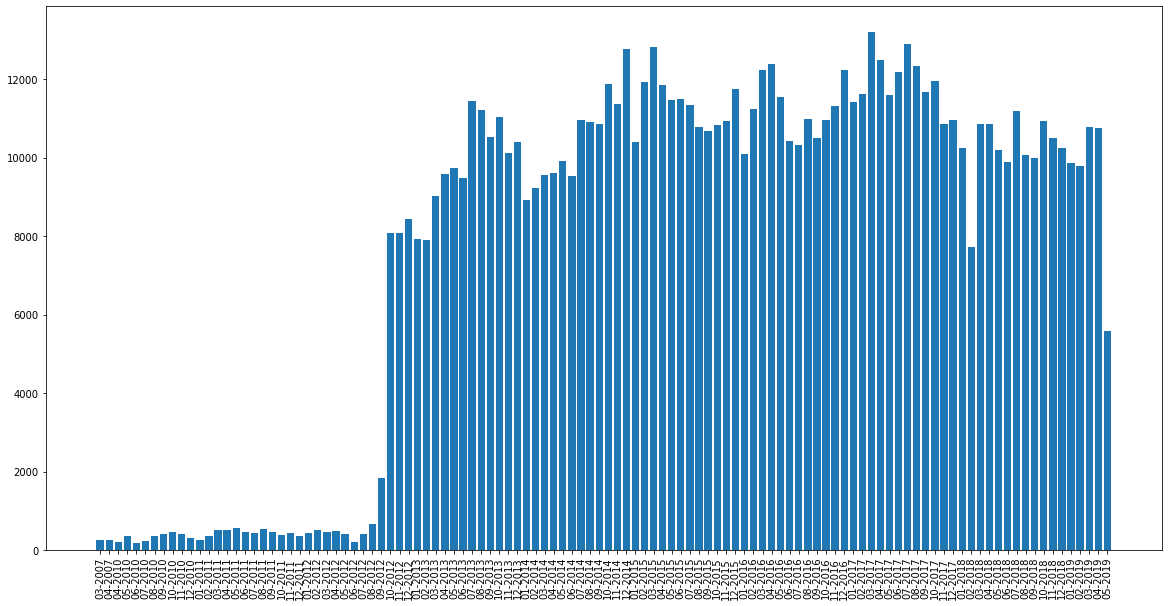

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
plt.show()

In [25]:
# Удалим часть символов

In [26]:
import re

In [27]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\«", "", x))

In [28]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\»", "", x))

In [29]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\%", "", x))

In [30]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\,", "", x))

In [31]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\.", "", x))

In [32]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\—", "", x))

In [33]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\-", "", x))

In [34]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\:", "", x))

In [35]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\n", "", x))

In [36]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\/", "", x))

In [37]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\?", "", x))

In [38]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\)", "", x))

In [39]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\(", "", x))

In [40]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\"", "", x))

In [41]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\''", "", x))

In [42]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\'", "", x))

In [43]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\#", "", x))

In [44]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\;", "", x))

In [45]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\@", "", x))

In [46]:
data_gazeta.text = data_gazeta.text.apply(lambda x: re.sub("\–", "", x))

In [47]:
def text_to_token(text):
    text = text.lower()
    return wordpunct_tokenize(text)

In [48]:
def data_withoun_stopwords(text):
    text = [token for token in text if token not in stopwords]
    return text

In [49]:
dictionary_with_stopwords = FreqDist()

In [50]:
dictionary_without_stopwords = FreqDist()

In [51]:
for token in data_gazeta.text.values:
    dictionary_with_stopwords.update(text_to_token(token))

In [56]:
stopwords = open('../nlp/preprocessing/stopwords.txt', 'r')
stopwords = stopwords.read().split('\n')
stopwords += ["c","а","алло","без","белый","близко","более","больше","большой","будем","будет","будете","будешь","будто","буду","будут","будь","бы","бывает","бывь","был","была","были","было","быть","в","важная","важное","важные","важный","вам","вами","вас","ваш","ваша","ваше","ваши","вверх","вдали","вдруг","ведь","везде","вернуться","весь","вечер","взгляд","взять","вид","видел","видеть","вместе","вне","вниз","внизу","во","вода","война","вокруг","вон","вообще","вопрос","восемнадцатый","восемнадцать","восемь","восьмой","вот","впрочем","времени","время","все","все еще","всегда","всего","всем","всеми","всему","всех","всею","всю","всюду","вся","всё","второй","вы","выйти","г","где","главный","глаз","говорил","говорит","говорить","год","года","году","голова","голос","город","да","давать","давно","даже","далекий","далеко","дальше","даром","дать","два","двадцатый","двадцать","две","двенадцатый","двенадцать","дверь","двух","девятнадцатый","девятнадцать","девятый","девять","действительно","дел","делал","делать","делаю","дело","день","деньги","десятый","десять","для","до","довольно","долго","должен","должно","должный","дом","дорога","друг","другая","другие","других","друго","другое","другой","думать","душа","е","его","ее","ей","ему","если","есть","еще","ещё","ею","её","ж","ждать","же","жена","женщина","жизнь","жить","за","занят","занята","занято","заняты","затем","зато","зачем","здесь","земля","знать","значит","значить","и","иди","идти","из","или","им","имеет","имел","именно","иметь","ими","имя","иногда","их","к","каждая","каждое","каждые","каждый","кажется","казаться","как","какая","какой","кем","книга","когда","кого","ком","комната","кому","конец","конечно","которая","которого","которой","которые","который","которых","кроме","кругом","кто","куда","лежать","лет","ли","лицо","лишь","лучше","любить","люди","м","маленький","мало","мать","машина","между","меля","менее","меньше","меня","место","миллионов","мимо","минута","мир","мира","мне","много","многочисленная","многочисленное","многочисленные","многочисленный","мной","мною","мог","могу","могут","мож","может","может быть","можно","можхо","мои","мой","мор","москва","мочь","моя","моё","мы","на","наверху","над","надо","назад","наиболее","найти","наконец","нам","нами","народ","нас","начала","начать","наш","наша","наше","наши","не","него","недавно","недалеко","нее","ней","некоторый","нельзя","нем","немного","нему","непрерывно","нередко","несколько","нет","нею","неё","ни","нибудь","ниже","низко","никакой","никогда","никто","никуда","ним","ними","них","ничего","ничто","но","новый","нога","ночь","ну","нужно","нужный","нх","о","об","оба","обычно","один","одиннадцатый","одиннадцать","однажды","однако","одного","одной","оказаться","окно","около","он","она","они","оно","опять","особенно","остаться","от","ответить","отец","откуда","отовсюду","отсюда","очень","первый","перед","писать","плечо","по","под","подойди","подумать","пожалуйста","позже","пойти","пока","пол","получить","помнить","понимать","понять","пор","пора","после","последний","посмотреть","посреди","потом","потому","почему","почти","правда","прекрасно","при","про","просто","против","процентов","путь","пятнадцатый","пятнадцать","пятый","пять","работа","работать","раз","разве","рано","раньше","ребенок","решить","россия","рука","русский","ряд","рядом","с","с кем","сам","сама","сами","самим","самими","самих","само","самого","самой","самом","самому","саму","самый","свет","свое","своего","своей","свои","своих","свой","свою","сделать","сеаой","себе","себя","сегодня","седьмой","сейчас","семнадцатый","семнадцать","семь","сидеть","сила","сих","сказал","сказала","сказать","сколько","слишком","слово","случай","смотреть","сначала","снова","со","собой","собою","советский","совсем","спасибо","спросить","сразу","стал","старый","стать","стол","сторона","стоять","страна","суть","считать","т","та","так","такая","также","таки","такие","такое","такой","там","твои","твой","твоя","твоё","те","тебе","тебя","тем","теми","теперь","тех","то","тобой","тобою","товарищ","тогда","того","тоже","только","том","тому","тот","тою","третий","три","тринадцатый","тринадцать","ту","туда","тут","ты","тысяч","у","увидеть","уж","уже","улица","уметь","утро","хороший","хорошо","хотел бы","хотеть","хоть","хотя","хочешь","час","часто","часть","чаще","чего","человек","чем","чему","через","четвертый","четыре","четырнадцатый","четырнадцать","что","чтоб","чтобы","чуть","шестнадцатый","шестнадцать","шестой","шесть","эта","эти","этим","этими","этих","это","этого","этой","этом","этому","этот","эту","я","являюсь"]

In [57]:
for token in data_gazeta.text.values:
    dictionary_without_stopwords.update(data_withoun_stopwords(text_to_token(token)))

In [52]:
# Посмотрим 20 самых популярных слов без удаления стопслов и построим по ним график
dictionary_with_stopwords.most_common(20)

[('в', 5452963),
 ('и', 2962902),
 ('на', 2426852),
 ('что', 1654656),
 ('с', 1488490),
 ('не', 1333364),
 ('по', 1032857),
 ('а', 529783),
 ('из', 523030),
 ('за', 521927),
 ('о', 511686),
 ('россии', 493725),
 ('к', 466215),
 ('но', 415581),
 ('это', 409264),
 ('для', 403003),
 ('как', 375180),
 ('от', 370082),
 ('у', 365602),
 ('он', 363421)]

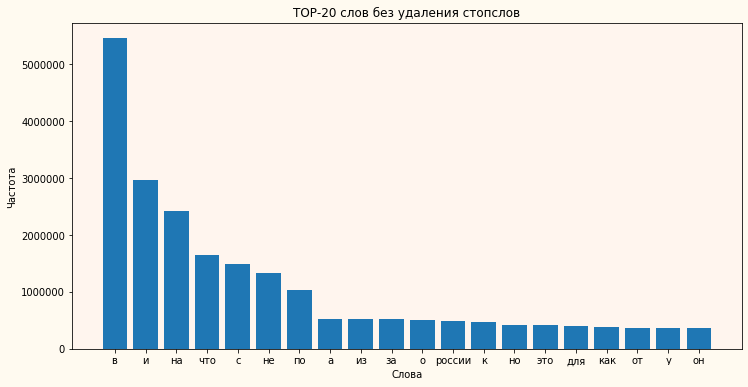

In [53]:
x = dict(dictionary_with_stopwords.most_common(20)).keys()
y = dict(dictionary_with_stopwords.most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

In [58]:
# Посмотрим 20 самых популярных слов после удаления стопслов и построим по ним график
dictionary_without_stopwords.most_common(20)

[('россии', 493725),
 ('заявил', 215017),
 ('сша', 189469),
 ('!', 154714),
 ('матче', 135237),
 ('словам', 134684),
 ('чемпионата', 125473),
 ('другими', 117898),
 ('команды', 116358),
 ('сборной', 111929),
 ('новостями', 109999),
 ('материалами', 109867),
 ('статистикой', 108591),
 ('изза', 105191),
 ('млн', 98655),
 ('украины', 95764),
 ('можете', 95506),
 ('ссылкой', 93561),
 ('$', 91146),
 ('отметил', 89741)]

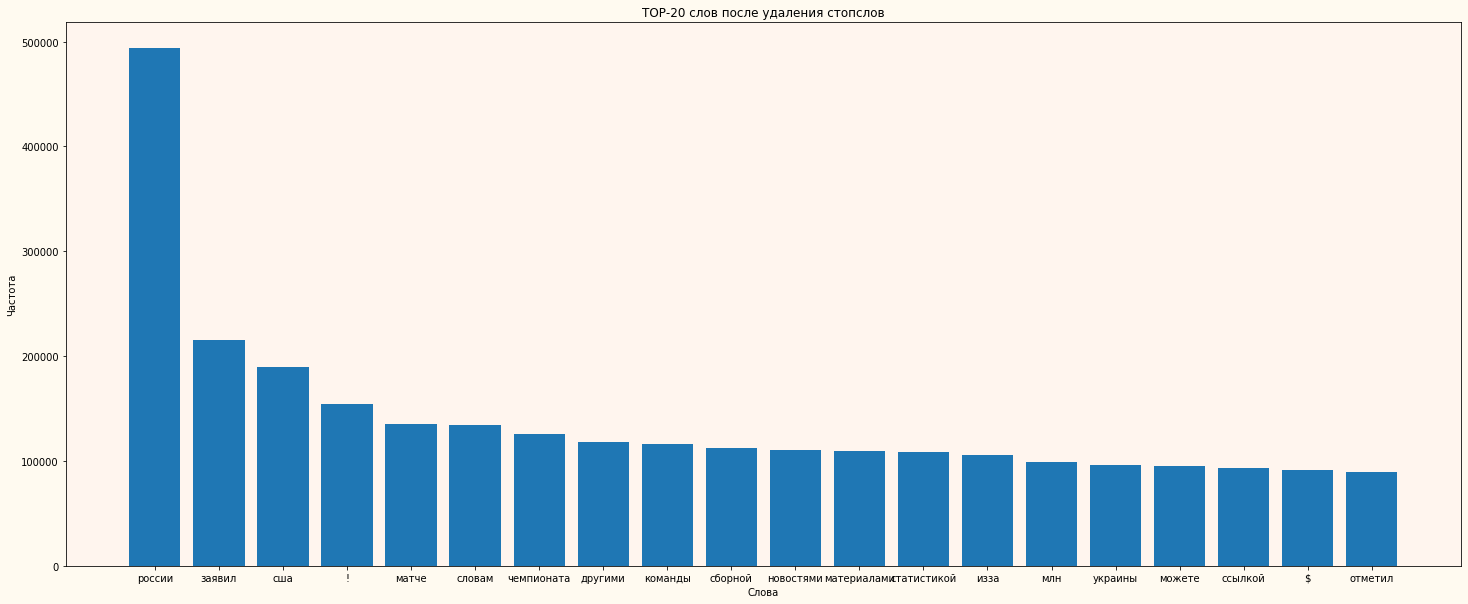

In [59]:
x = dict(dictionary_without_stopwords.most_common(20)).keys()
y = dict(dictionary_without_stopwords.most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов после удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(25)    #  ширина Figure
fig.set_figheight(10)    #  высота Figure


plt.show()

### Рубрики gazeta

In [54]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data_gazeta.topics.unique().shape)
data_gazeta['topics'].unique()

Количество рубрик =  (12,)


array(['Бизнес', 'Наука', 'Армия', 'Новости', 'Политика', 'Культура',
       'Спорт', 'Общество', 'Стиль', 'Технологии', 'Авто', 'Мнения'],
      dtype=object)

Все рубрики, с количеством новостей в каждой группе

In [55]:
data_gazeta.groupby('topics')['topics'].count()

topics
Авто           46469
Армия          25520
Бизнес        105365
Культура       42289
Мнения           890
Наука          17257
Новости        13246
Общество      163364
Политика      100213
Спорт         318845
Стиль          12875
Технологии     19379
Name: topics, dtype: int64